<a href="https://colab.research.google.com/github/davidruizduarte/stablediffusion_webui/blob/main/Copia_de_DreamBooth_Stable_Diffusion_SDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-click execution of Dreambooth Stable Diffusion

Tutorials and prompts at [https://linktr.ee/viajatech](https://linktr.ee/viajatech)



In [ ]:
import time

#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "SG161222/Realistic_Vision_V2.0" #@param {type:"string"}
BRANCH = "main" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of edie" #@param {type:"string"}
class_prompt =  "edie" #@param {type:"string"}
training_steps = 500 #@param {type:"integer"}
learning_rate = 5e-6 #@param {type:"number"}
output_file = "AI_PICS/models/my_dreambooth_model.safetensors" #@param {type:"string"}
#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}

#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR

!rm -rf $OUTPUT_DIR
!mkdir -p $OUTPUT_DIR

if 'pipe' in locals():
  del pipe

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/davidruizduarte/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --revision=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################
#prompt = "photo of zwx"
prompt = instance_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np



if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None




g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')


######################################
# Save to checkpoint file
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

Mounted at /content/drive
Tesla T4, 15360 MiB, 15101 MiB


Saving 466b62644c51908061e578ce81a54112.jpg to 466b62644c51908061e578ce81a54112.jpg
Saving 740full-edie-campbell.jpg to 740full-edie-campbell.jpg
Saving 182120!1485185060!ysl__get_a_shock_1.jpg to 182120!1485185060!ysl__get_a_shock_1.jpg
Saving 183607_original-377-768x1151.jpg to 183607_original-377-768x1151.jpg
Saving 256218_original-162-768x513.jpg to 256218_original-162-768x513.jpg
Saving 256318_original-240-768x1152.jpg to 256318_original-240-768x1152.jpg
Saving 06152046-9764-fish-m.com.jpg to 06152046-9764-fish-m.com.jpg
Saving 196241189814068059465.jpg to 196241189814068059465.jpg
Saving Black_Opium-Edie_Campbell-4.jpg to Black_Opium-Edie_Campbell-4.jpg
Saving Black_Opium-Edie_Campbell-10.jpg to Black_Opium-Edie_Campbell-10.jpg
Saving Black_Opium-Edie_Campbell-12.jpg to Black_Opium-Edie_Campbell-12.jpg
Saving Black_Opium-Edie_Campbell-13.jpg to Black_Opium-Edie_Campbell-13.jpg
Saving Black_Opium-Edie_Campbell-14.jpg to Black_Opium-Edie_Campbell-14.jpg
Saving Black_Opium-Edie_Camp

/content


  0%|          | 0/25 [00:00<?, ?it/s]

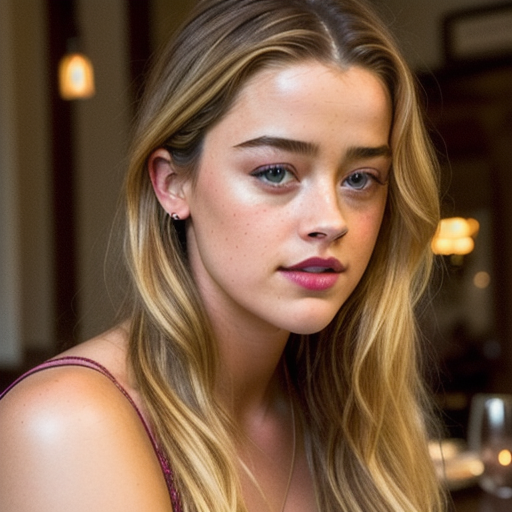

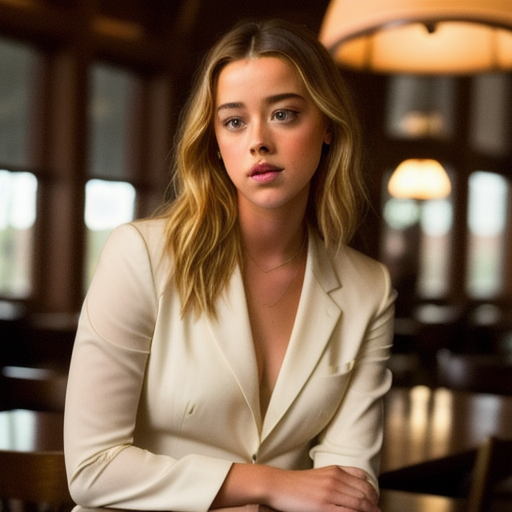

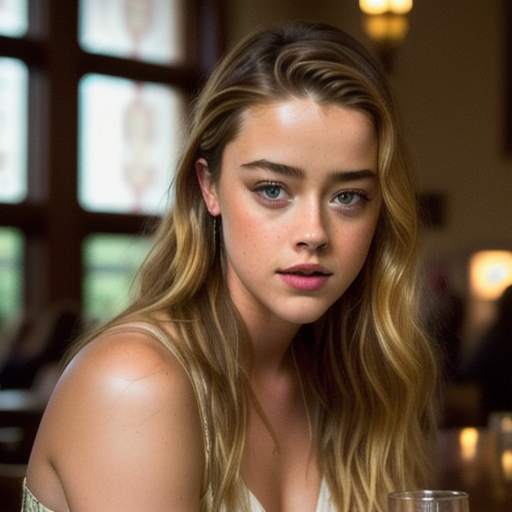

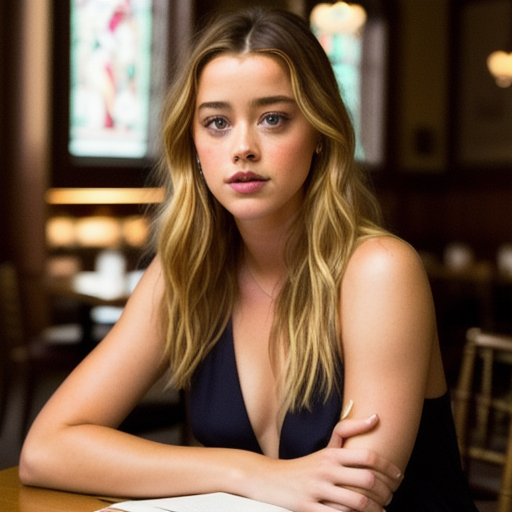

In [ ]:
#@title Test image generation from model

prompt = "Photo of edie, sitting in a restaurant, side lighting," #@param {type:"string"}
negative_prompt = "disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 13.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)